===== TRAINING CSV INFO =====
CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1067
Rows that have all features = NaN: 21
TRAIN rows: 938
VAL   rows: 108
TEST  rows: 21
===== START TRAINING OR LOADING MODELS =====

=== Training/Loading LSTM model ===
[LSTM] Loaded existing model from ./best_LSTM_Silver_V1.pt
LSTM => Completed test predictions

=== Training/Loading GRU model ===
[GRU] Loaded existing model from ./best_GRU_Silver_V1.pt
GRU => Completed test predictions

=== Training/Loading RNN model ===
[RNN] Loaded existing model from ./best_RNN_Silver_V1.pt
RNN => Completed test predictions

=== Training/Loading CNN model ===
[CNN] Loaded existing model from ./best_CNN_Silver_V1.pt
CNN => Completed test predictions

=== Training/Loading Transformer model ===
[Transformer] Loaded existing model from ./best_Transformer_Silver_V1.pt
Transformer => Completed test predictions

=== Training/Loading N-BEATS model ===
[N-BEATS] Loaded exist

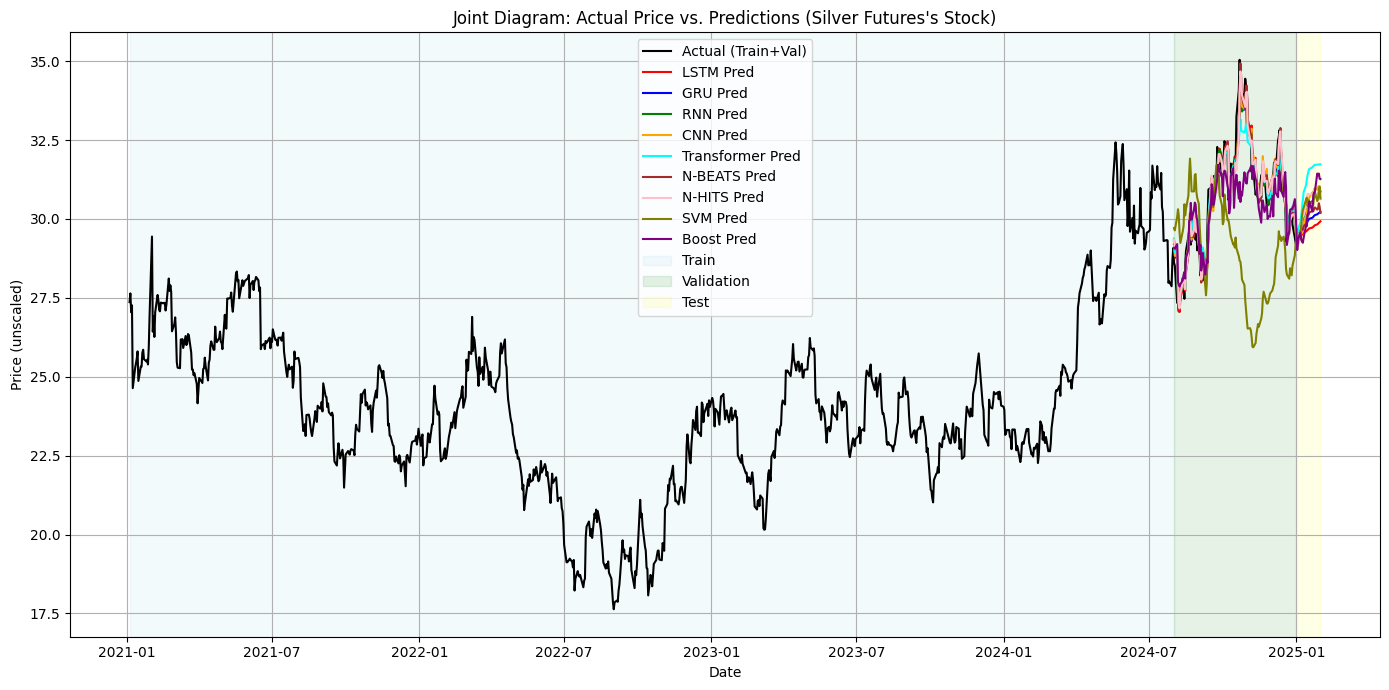

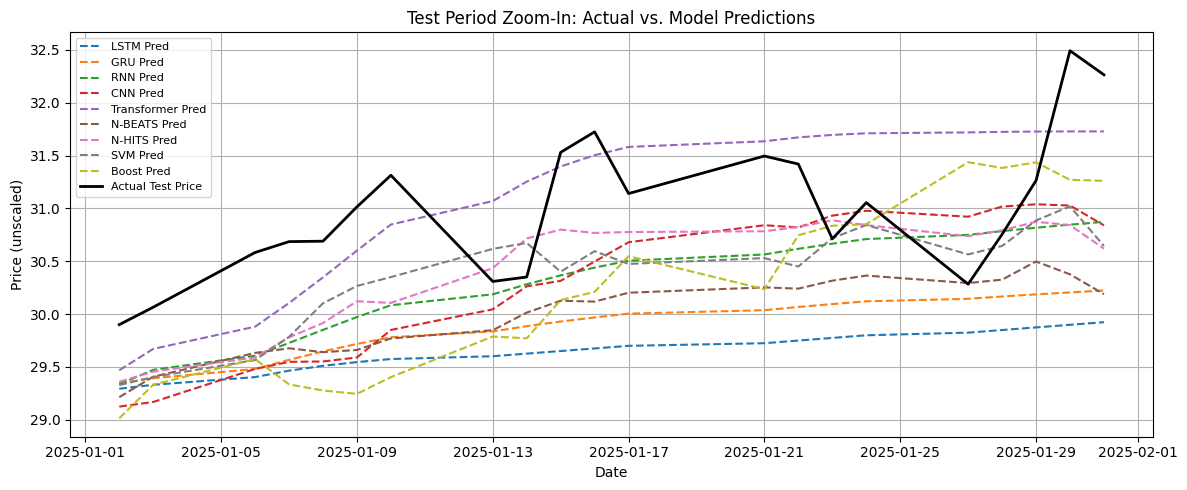


===== ROLLING FORECASTS (MOE) from 2025-01-01 to 2025-01-31 =====
   ForecastDate  Pred_Price_unscaled  Pred_Open_unscaled  Pred_High_unscaled  \
0    2025-01-01            29.013161           29.391573           29.530006   
1    2025-01-02            29.331184           29.065477           29.318697   
2    2025-01-03            29.573997           29.441969           29.690714   
3    2025-01-04            29.334976           29.451191           29.705252   
4    2025-01-05            29.276463           29.462114           29.642984   
5    2025-01-06            29.244856           29.217316           29.590302   
6    2025-01-07            29.403530           29.218981           29.624056   
7    2025-01-08            29.787592           29.477278           29.839664   
8    2025-01-09            29.770872           29.608284           30.037613   
9    2025-01-10            30.132757           29.731133           30.473475   
10   2025-01-11            30.210171           29.745

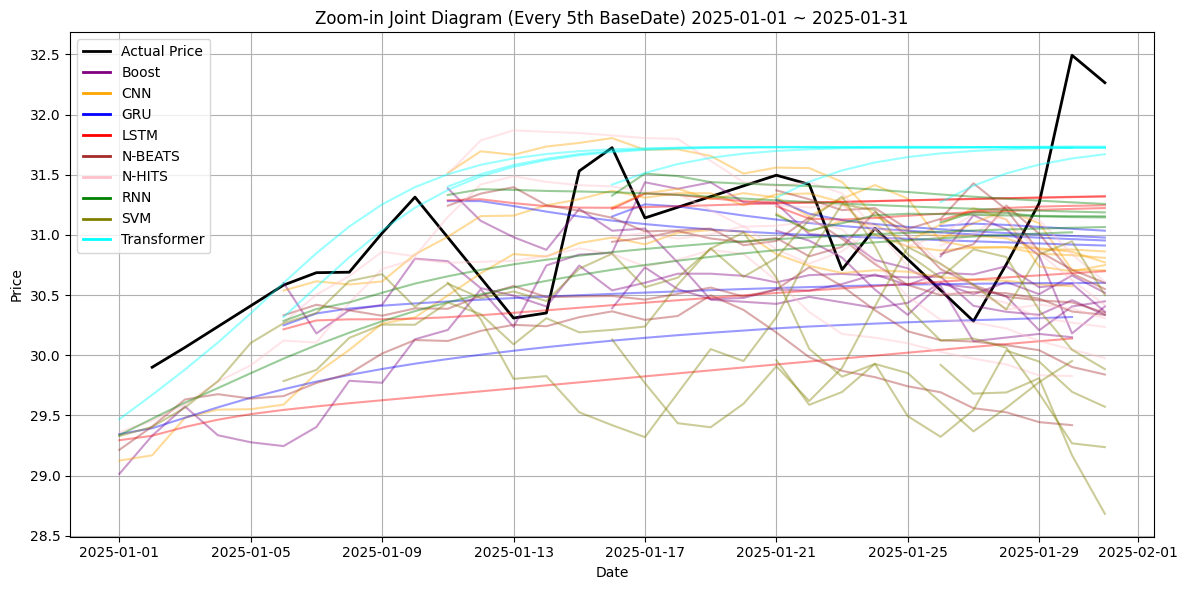

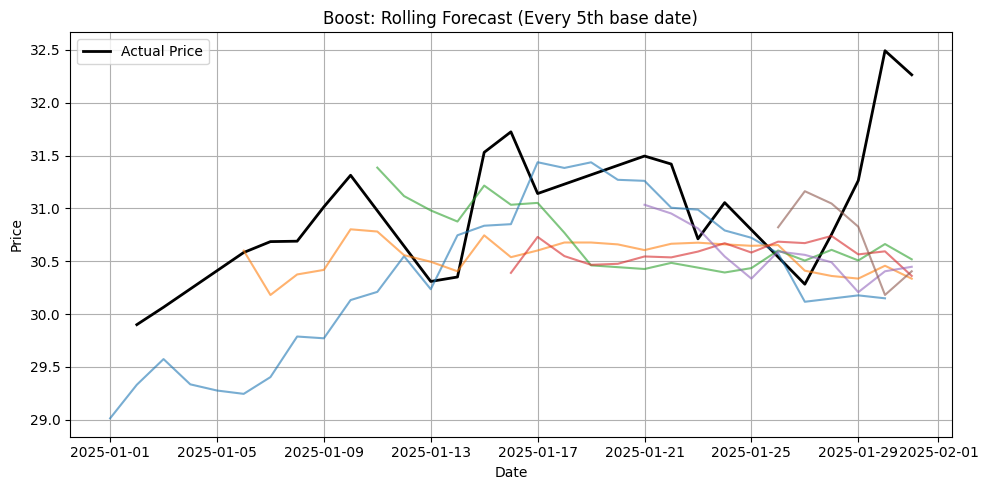

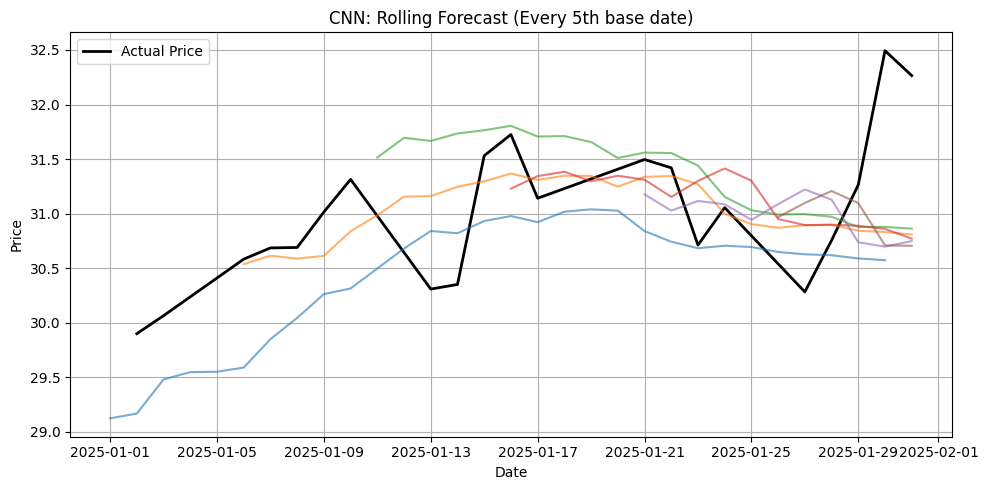

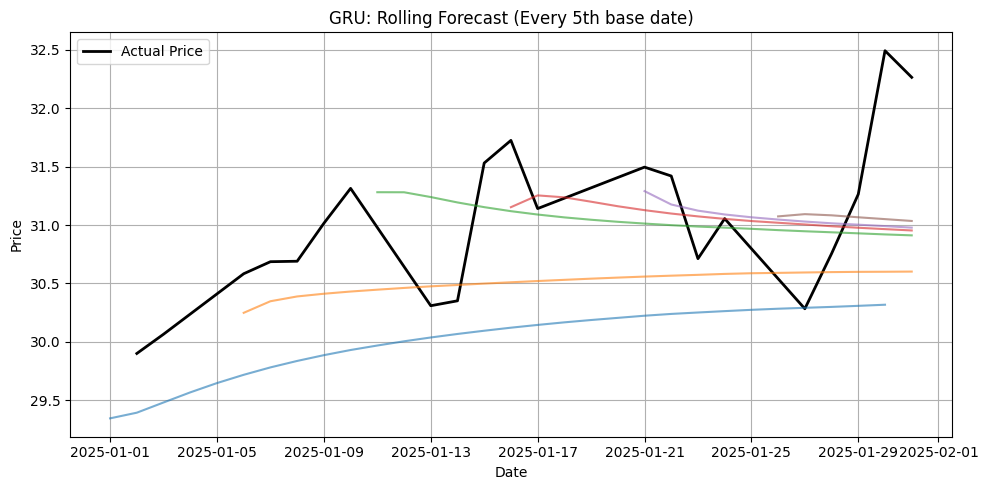

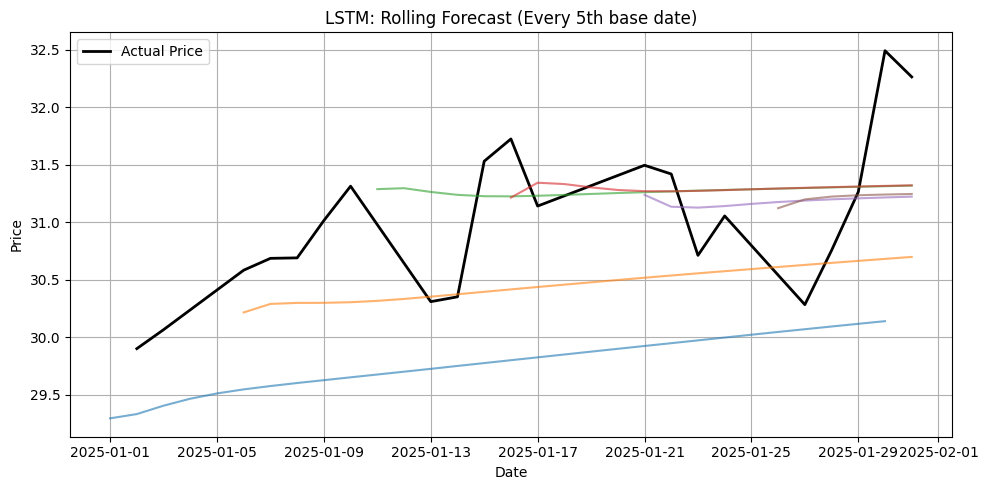

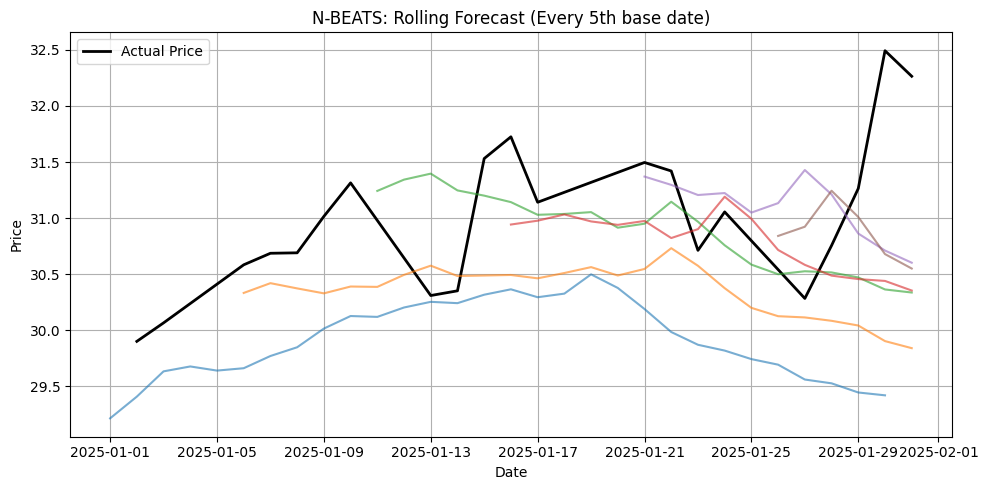

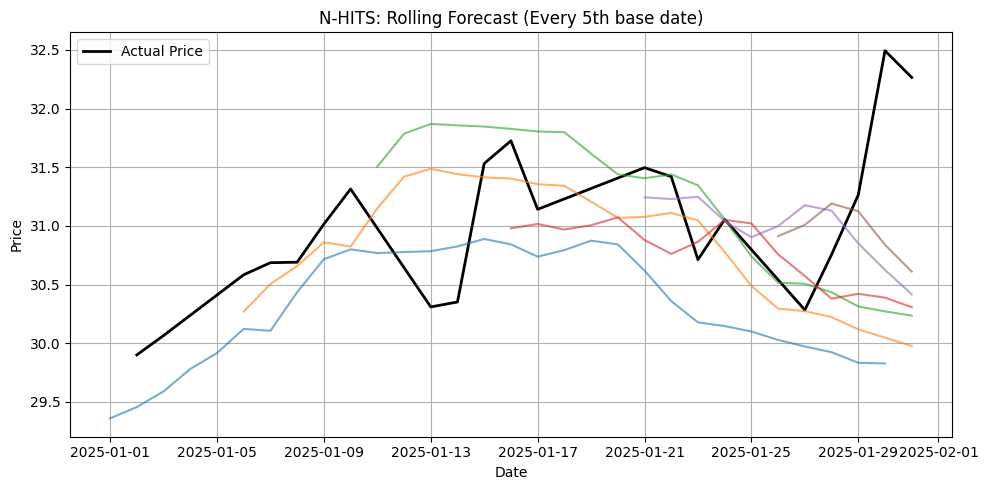

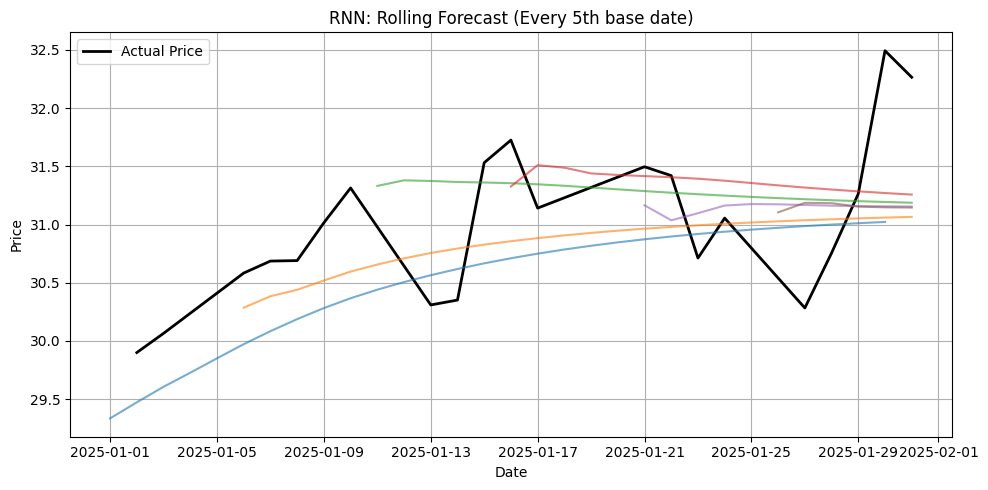

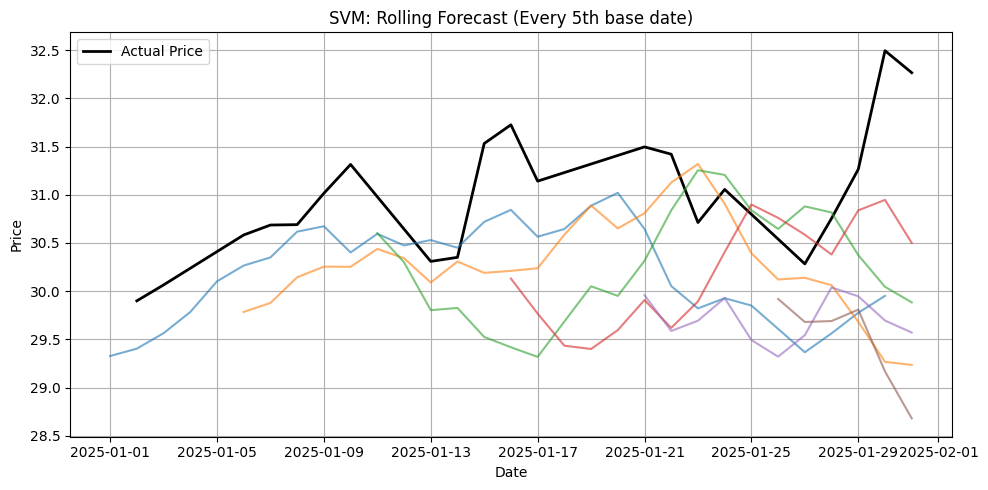

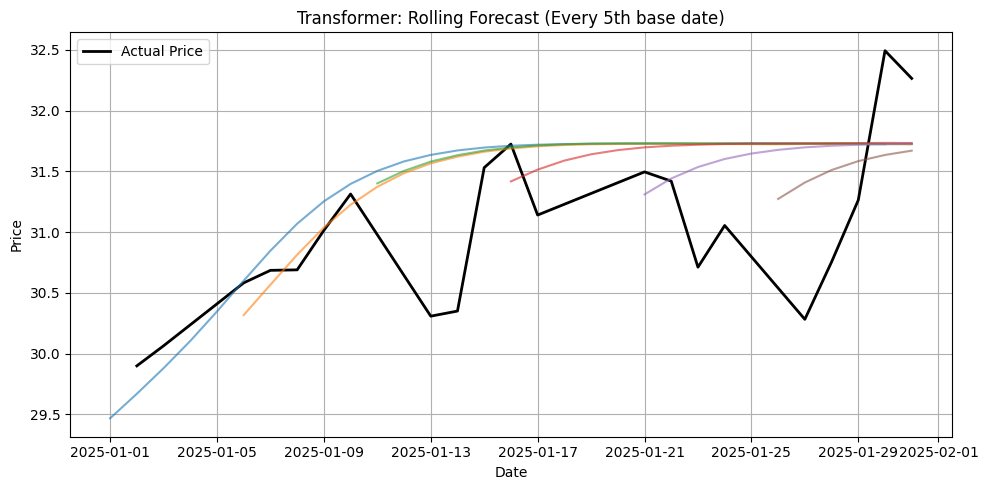


=== 2025-01-02 ===
  Model=Transformer, Error=0.230, Conf=1.000
  Model=RNN, Error=0.427, Conf=0.699
  Model=Transformer, Error=0.432, Conf=0.693

=== 2025-01-03 ===
  Model=Boost, Error=0.004, Conf=1.000
  Model=Transformer, Error=0.078, Conf=0.918
  Model=Transformer, Error=0.184, Conf=0.799

=== 2025-01-06 ===
  Model=CNN, Error=0.005, Conf=1.000
  Model=Transformer, Error=0.015, Conf=0.992
  Model=Boost, Error=0.018, Conf=0.990

=== 2025-01-07 ===
  Model=N-HITS, Error=0.028, Conf=1.000
  Model=N-HITS, Error=0.039, Conf=0.993
  Model=Transformer, Error=0.051, Conf=0.984

=== 2025-01-08 ===
  Model=CNN, Error=0.008, Conf=1.000
  Model=RNN, Error=0.009, Conf=0.999
  Model=LSTM, Error=0.023, Conf=0.988

=== 2025-01-09 ===
  Model=Transformer, Error=0.023, Conf=1.000
  Model=CNN, Error=0.031, Conf=0.995
  Model=N-HITS, Error=0.035, Conf=0.991

=== 2025-01-10 ===
  Model=Transformer, Error=0.012, Conf=1.000
  Model=Transformer, Error=0.024, Conf=0.993
  Model=Transformer, Error=0.059, 

/tmp/ipykernel_461651/1886800983.py:758: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_out = df_merged.groupby("ForecastDate", group_keys=False).apply(group_conf)


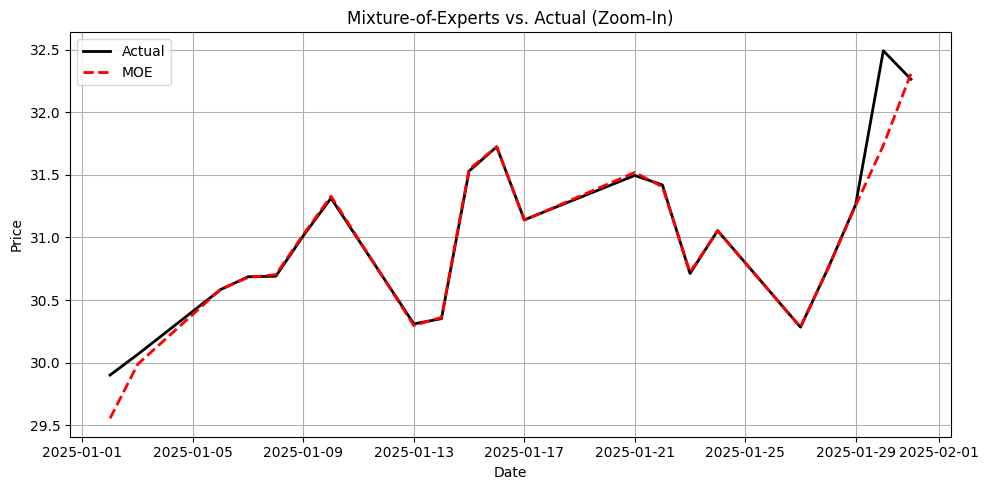


All done.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# 1) SUPPRESS ALL WARNINGS
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
pd.options.mode.chained_assignment = None

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import joblib
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.lines import Line2D
import matplotlib.dates as mdates

# ============================================
# Global seeds & settings
# ============================================
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# Hyperparameters
WINDOW_SIZE = 35
NUM_EPOCHS  = 800
features = ["Price", "Open", "High", "Low"]



# File paths
csv_file_train    = "Silver Futures Historical Data.csv"
csv_file_complete = "Silver Futures Historical Data_Complete.csv"
best_models_dir   = "."

# ============================================
# 2. Load & Clean CSV for Training
# ============================================
df = pd.read_csv(csv_file_train)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)



for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)


print("===== TRAINING CSV INFO =====")
print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:", df[features].isna().all(axis=1).sum())

# Cutoffs
train_cutoff = pd.to_datetime("2024-08-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-01")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

# ============================================
# 3. Fit MinMaxScaler on TRAIN only
# ============================================
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

val_no_nan = df_val_scaled.dropna(subset=features)
if not val_no_nan.empty:
    df_val_scaled.loc[val_no_nan.index, features] = scaler.transform(val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)
joblib.dump(scaler, "scaler.pkl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================
# 4. Create training sequences
# ============================================
def make_sequences(df_subset, window=35):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window: i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

X_train_flat = X_train_all.reshape((X_train_all.shape[0], WINDOW_SIZE * 4))

# ============================================
# 5. Validation Utilities
# ============================================
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=35):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width
        
        if model_type == "CNN":
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)
        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        elif model_type == "Transformer":
            self.input_linear = nn.Linear(4, 128)
            encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, dropout=0.1)
            self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
            self.fc = nn.Linear(128, 4)
        elif model_type == "N-BEATS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        elif model_type == "N-HITS":
            self.input_size = window_width * 4
            self.blocks = nn.ModuleList([nn.Sequential(
                nn.Linear(self.input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, 4)
            ) for _ in range(3)])
        else:
            raise ValueError("Invalid model_type")
    
    def forward(self, x):
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type in ["LSTM", "GRU", "RNN"]:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        elif self.model_type == "Transformer":
            x = self.input_linear(x)
            x = x.permute(1, 0, 2)
            x = self.transformer_encoder(x)
            x = x[-1, :, :]
            out = self.fc(x)
        elif self.model_type in ["N-BEATS", "N-HITS"]:
            x_flat = x.reshape(x.size(0), -1)
            forecast = 0
            for block in self.blocks:
                forecast += block(x_flat)
            out = forecast
        else:
            raise ValueError("Invalid model_type")
        return out

def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=35):
    criterion = nn.MSELoss()
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())

    model.eval()
    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features].values
            if np.isnan(window_df).any():
                continue
            X_input = torch.tensor(window_df, dtype=torch.float).unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu()[0]
            true_vals = df_work.loc[idx_current, features].values.astype(float, copy=False)
            if np.isnan(true_vals).any():
                continue
            loss = criterion(pred_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())
    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

def half_blind_validation_preds_df(model, df_scaled, val_start, val_end, window=35):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = np.sort(df_work.loc[val_mask, "Date"].unique())

    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue
            window_df = df_work.iloc[start_idx:idx_current][features].values
            if np.isnan(window_df).any():
                continue
            X_input = torch.tensor(window_df, dtype=torch.float).unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))

    pred_df = pd.DataFrame(preds, columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"])
    pred_df.sort_values("Date", inplace=True)
    arr_scaled = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    arr_unscaled = inverse_transform_4cols(arr_scaled)
    pred_df["Pred_Price_unscaled"] = arr_unscaled[:,0]
    pred_df["Pred_Open_unscaled"]  = arr_unscaled[:,1]
    pred_df["Pred_High_unscaled"]  = arr_unscaled[:,2]
    pred_df["Pred_Low_unscaled"]   = arr_unscaled[:,3]
    return pred_df

def iterative_half_blind_validation_preds(model, df_all_scaled, val_start, val_end, window=35):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    val_idx = df_work.index[df_work["Date"] >= val_start]
    if len(val_idx) == 0:
        raise ValueError("No validation data after val_start")
    first_val_idx = val_idx[0]

    current_window = df_work.iloc[first_val_idx - window:first_val_idx][features].values
    model.eval()
    preds = []
    val_dates = np.sort(df_work[df_work["Date"] >= val_start]["Date"].unique())
    with torch.no_grad():
        for d in val_dates:
            if d> val_end:
                break
            X_input = torch.tensor(current_window, dtype=torch.float).unsqueeze(0).to(device)
            pred_scaled = model(X_input).cpu().numpy()[0]
            preds.append((d, *pred_scaled))

            # Reveal actual
            actual_row = df_work[df_work["Date"] == d][features].values
            if actual_row.shape[0] > 0:
                current_window = np.vstack((current_window[1:], actual_row[0]))

    pred_df = pd.DataFrame(preds, columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"])
    pred_df.sort_values("Date", inplace=True)
    arr_scaled = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    arr_unscaled = inverse_transform_4cols(arr_scaled)
    pred_df["Pred_Price_unscaled"] = arr_unscaled[:,0]
    pred_df["Pred_Open_unscaled"]  = arr_unscaled[:,1]
    pred_df["Pred_High_unscaled"]  = arr_unscaled[:,2]
    pred_df["Pred_Low_unscaled"]   = arr_unscaled[:,3]
    return pred_df

# ============================================
# 6B. Train model
# ============================================
def train_model(model_type="LSTM", num_epochs=800):
    best_path = os.path.join(best_models_dir, f"best_{model_type}_Silver_V1.pt")
    model = BaseModel(model_type, WINDOW_SIZE).to(device)

    if os.path.exists(best_path):
        model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"[{model_type}] Loaded existing model from {best_path}")
        return model

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    early_stopper = EarlyStopping(patience=150)
    best_loss = float("inf")

    for epoch in range(num_epochs):
        model.train()
        train_losses=[]
        for Xb,yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_loss = half_blind_validation_loss(model, df_scaled, train_cutoff, val_cutoff, WINDOW_SIZE)
        early_stopper(val_loss)
        if val_loss< best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), best_path)
        if early_stopper.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break

    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

class SklearnWrapper:
    def __init__(self, model):
        self.model = model
    def forward(self, x):
        arr = x.cpu().numpy().reshape(1,-1)
        pred = self.model.predict(arr)
        return torch.from_numpy(pred).float().to(x.device)
    def eval(self):
        pass
    def __call__(self, x):
        return self.forward(x)

def train_model_sklearn(model_type, X_flat, y_train):
    best_path = os.path.join(best_models_dir, f"best_{model_type}_Silver_V1.pkl")
    if os.path.exists(best_path):
        model = joblib.load(best_path)
        print(f"[{model_type}] Loaded existing model from {best_path}")
    else:
        if model_type=="SVM":
            base=SVR(kernel='rbf', C=10, epsilon=0.01)
        elif model_type=="GPR":
            kernel = 1.0
            base=GaussianProcessRegressor(alpha=1e-2)
        elif model_type=="Boost":
            base=GradientBoostingRegressor(n_estimators=200,max_depth=3)
        else:
            raise ValueError("Unsupported sklearn model")

        multi_model= MultiOutputRegressor(base)
        multi_model.fit(X_flat,y_train)
        joblib.dump(multi_model, best_path)
        model = multi_model
    return SklearnWrapper(model)

# ============================================
# 9. Walk-forward test
# ============================================
def walk_forward_test(model, df_all_scaled, test_start, window=35):
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)
    preds=[]
    test_dates = np.sort(df_work[df_work["Date"]>=test_start]["Date"].unique())

    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx = df_work.index[df_work["Date"]==d]
            if len(idx)==0: continue
            idx=idx[0]
            start_idx= idx-window
            if start_idx<0: continue
            window_df = df_work.iloc[start_idx:idx][features].values
            if np.isnan(window_df).any(): continue
            X_input= torch.tensor(window_df, dtype=torch.float).unsqueeze(0).to(device)
            y_pred_scaled = model(X_input).cpu().numpy()[0]
            df_work.loc[idx,features] = y_pred_scaled
            preds.append((d,*y_pred_scaled))

    pred_df = pd.DataFrame(preds, columns=["Date","Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"])
    arr_scaled = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    arr_unscaled = inverse_transform_4cols(arr_scaled)
    pred_df["Pred_Price_unscaled"] = arr_unscaled[:,0]
    pred_df["Pred_Open_unscaled"]  = arr_unscaled[:,1]
    pred_df["Pred_High_unscaled"]  = arr_unscaled[:,2]
    pred_df["Pred_Low_unscaled"]   = arr_unscaled[:,3]
    return pred_df.sort_values("Date")

# ============================================
# 10. Evaluate & Plot
# ============================================
def evaluate_and_plot_all_models(results_dict, df_scaled, df_train, train_cutoff, val_cutoff, test_cutoff):
    df_real = df_scaled[["Date","Price","Open","High","Low"]].copy()
    df_real.sort_values("Date", inplace=True)
    mask_trainval = (df_real["Date"]<test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    arr_scaled = df_real_plot[features].values
    arr_unscaled = inverse_transform_4cols(arr_scaled)
    df_real_plot["Real_Price_unscaled"] = arr_unscaled[:,0]

    plt.figure(figsize=(14,7))
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"], color="black", label="Actual (Train+Val)")

    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)
    
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }

    for mname, info in results_dict.items():
        val_df = info["val_pred_df"]
        test_df= info["test_pred_df"]
        frames=[]
        if val_df is not None:
            frames.append(val_df.rename(columns={"Pred_Price_unscaled":f"Pred_{mname}"}))
        if test_df is not None:
            frames.append(test_df.rename(columns={"Pred_Price_unscaled":f"Pred_{mname}"}))
        if frames:
            comb = pd.concat(frames, ignore_index=True)
            comb=comb[["Date",f"Pred_{mname}"]].drop_duplicates("Date")
            comb.sort_values("Date", inplace=True)
            merged_df = pd.merge(merged_df, comb,on="Date",how="left")

    for mname in results_dict.keys():
        col = f"Pred_{mname}"
        if col in merged_df.columns:
            plt.plot(merged_df["Date"], merged_df[col],
                     color=color_map.get(mname,"gray"), linestyle="-", label=f"{mname} Pred")

    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")

    plt.title("Joint Diagram: Actual Price vs. Predictions (Silver Futures's Stock)")
    plt.xlabel("Date")
    plt.ylabel("Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Zoom for test period
    df_test_zoom = merged_df[merged_df["Date"]>=test_cutoff]
    if not df_test_zoom.empty:
        plt.figure(figsize=(12,5))
        for mname in results_dict.keys():
            col = f"Pred_{mname}"
            if col in df_test_zoom.columns:
                plt.plot(df_test_zoom["Date"], df_test_zoom[col], linestyle="--", label=f"{mname} Pred")
        # overlay actual from CSV
        df_full = pd.read_csv(csv_file_complete)
        df_full["Date"] = pd.to_datetime(df_full["Date"])
        df_full.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
        df_full.sort_values("Date", inplace=True)
        df_test_only = df_full[df_full["Date"]>= test_cutoff].copy()
        plt.plot(df_test_only["Date"], df_test_only["Price"], color="black", lw=2, label="Actual Test Price")

        plt.title("Test Period Zoom-In: Actual vs. Model Predictions")
        plt.xlabel("Date")
        plt.ylabel("Price (unscaled)")
        plt.legend(prop={'size':8})
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ============================================
# 11A. We do the rolling forecast
# ============================================
def get_latest_window(actual_df, current_date, window=35, scaler=None):
    mask = actual_df["Date"]< current_date
    df_sub = actual_df.loc[mask].copy()
    df_sub.sort_values("Date", inplace=True)
    if len(df_sub)< window: return None
    df_window = df_sub.iloc[-window:].copy()
    df_window[features] = df_window[features].fillna(method="ffill").fillna(method="bfill")
    arr = scaler.transform(df_window[features])
    return arr

def forecast_30_days_from_date(model, df_actual, start_date, window=35, horizon=30, device=torch.device("cpu"), scaler=None):
    arr_window = get_latest_window(df_actual, start_date, window, scaler)
    if arr_window is None:
        return pd.DataFrame()
    rolling_buffer = np.copy(arr_window)
    forecast_records = []
    current_date = pd.to_datetime(start_date)
    for i in range(horizon):
        X_input = torch.tensor(rolling_buffer, dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            pred_scaled = model(X_input).cpu().numpy()[0]
        pred_unscaled = scaler.inverse_transform(pred_scaled.reshape(1,-1))[0]
        dayx = current_date + pd.Timedelta(days=i)
        forecast_records.append({
            "ForecastDate": dayx,
            "Pred_Price_unscaled": pred_unscaled[0],
            "Pred_Open_unscaled":  pred_unscaled[1],
            "Pred_High_unscaled":  pred_unscaled[2],
            "Pred_Low_unscaled":   pred_unscaled[3],
        })
        # shift
        rolling_buffer = np.vstack((rolling_buffer[1:], pred_scaled.reshape(1,-1)))
    return pd.DataFrame(forecast_records)

def rolling_moe_forecasts(models_dict, df_actual, start_day="2025-01-01", end_day="2025-01-31",
                          window_size=35, horizon=30, device=None, scaler=None):
    df_actual["Date"] = pd.to_datetime(df_actual["Date"])
    start_day = pd.to_datetime(start_day)
    end_day   = pd.to_datetime(end_day)
    all_days = pd.date_range(start=start_day, end=end_day, freq="D")
    results_list=[]
    for base_date in all_days:
        for mname, mobj in models_dict.items():
            df_fcst = forecast_30_days_from_date(
                model=mobj, 
                df_actual=df_actual,
                start_date=base_date,
                window=window_size,
                horizon=horizon,
                device=device,
                scaler=scaler
            )
            if df_fcst.empty: 
                continue
            df_fcst["BaseDate"] = base_date
            df_fcst["Model"]    = mname
            results_list.append(df_fcst)
    df_all_fc = pd.concat(results_list, ignore_index=True)
    df_all_fc.sort_values(["Model","BaseDate","ForecastDate"], inplace=True)
    df_all_fc.reset_index(drop=True, inplace=True)
    return df_all_fc

# ============================================
# 11B. Single Joint Diagram (every 5th base date) but in one figure
# ============================================
def plot_joint_5day_forecasts_zoom_in(
    final_rolling_fcst,
    df_actual,
    start_date_plot = pd.to_datetime("2025-01-01"),
    end_date_plot   = pd.to_datetime("2025-01-31"),
    base_date_freq=5
):
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    df_plot = df_actual[
        (df_actual["Date"]>=start_date_plot) & (df_actual["Date"]<= end_date_plot)
    ].copy()

    unique_base = sorted(final_rolling_fcst["BaseDate"].unique())
    chosen_base_dates = [bd for i,bd in enumerate(unique_base) if i % base_date_freq==0]

    plt.figure(figsize=(12,6))
    # actual
    plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")

    models = final_rolling_fcst["Model"].unique()
    for m in models:
        df_m = final_rolling_fcst[final_rolling_fcst["Model"]==m].copy()
        c = color_map.get(m, "gray")
        for bd in chosen_base_dates:
            df_bd = df_m[df_m["BaseDate"]==bd].copy()
            df_bd = df_bd[(df_bd["ForecastDate"]>=start_date_plot) & (df_bd["ForecastDate"]<= end_date_plot)]
            if len(df_bd)==0: continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], color=c, alpha=0.4)

    # custom legend
    legend_elems = [Line2D([0],[0], color="black", lw=2, label="Actual Price")]
    for m in models:
        legend_elems.append(Line2D([0],[0], color=color_map.get(m,"gray"), lw=2, label=m))
    plt.legend(handles=legend_elems, loc="best")

    plt.title(f"Zoom-in Joint Diagram (Every 5th BaseDate) {start_date_plot.date()} ~ {end_date_plot.date()}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ============================================
# 11C. "9 Additional Plots" (one per model)
# ============================================
def plot_each_model_5days(final_rolling_fcst, df_actual, start_date_plot, end_date_plot, base_date_freq=5):
    """
    Creates 9 separate plots (one per model) for rolling predictions every 5th base date,
    focusing on [start_date_plot : end_date_plot].
    """
    models = sorted(final_rolling_fcst["Model"].unique())
    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta",
        "Transformer": "cyan",
        "N-BEATS": "brown",
        "N-HITS": "pink",
        "SVM": "olive",
        "GPR": "teal",
        "Boost": "purple"
    }
    df_plot = df_actual[
        (df_actual["Date"]>=start_date_plot) & (df_actual["Date"]<= end_date_plot)
    ].copy()

    # We'll pick every 5th base date:
    unique_base = sorted(final_rolling_fcst["BaseDate"].unique())
    chosen_base = [bd for i,bd in enumerate(unique_base) if i%base_date_freq==0]

    for m in models:
        df_m = final_rolling_fcst[final_rolling_fcst["Model"]==m].copy()
        plt.figure(figsize=(10,5))
        # plot actual
        plt.plot(df_plot["Date"], df_plot["Price"], color="black", lw=2, label="Actual Price")

        for bd in chosen_base:
            df_bd = df_m[df_m["BaseDate"]==bd].copy()
            df_bd= df_bd[(df_bd["ForecastDate"]>=start_date_plot) & (df_bd["ForecastDate"]<= end_date_plot)]
            if len(df_bd)==0: continue
            plt.plot(df_bd["ForecastDate"], df_bd["Pred_Price_unscaled"], alpha=0.6)

        plt.title(f"{m}: Rolling Forecast (Every 5th base date)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

# ============================================
# 11D. Confidence & MOE
# ============================================
def compute_confidences_and_top3(final_rolling_fcst, df_actual):
    """
    1) Merge final_rolling_fcst with actual Price on ForecastDate => AbsError.
    2) Min-max => Confidence in [0..1].
    3) Print top 3 models each day. (But we do not scale top3 to sum=1 here.)
    4) Return: [ForecastDate, Model, Pred_Price_unscaled, AbsError, Confidence, ActualPrice]
    """
    df_pred = final_rolling_fcst[["ForecastDate","Model","Pred_Price_unscaled"]].copy()
    df_a = df_actual.rename(columns={"Date":"ForecastDate","Price":"ActualPrice"})
    df_merged= pd.merge(df_pred, df_a[["ForecastDate","ActualPrice"]], on="ForecastDate", how="inner")
    df_merged.dropna(subset=["ActualPrice","Pred_Price_unscaled"], inplace=True)

    df_merged["AbsError"] = (df_merged["Pred_Price_unscaled"]- df_merged["ActualPrice"]).abs()

    # daily min-max
    def group_conf(grp):
        err_min= grp["AbsError"].min()
        err_max= grp["AbsError"].max()
        if abs(err_max-err_min)<1e-9:
            grp["Confidence"]=1.0
        else:
            grp["Confidence"]= 1.0 - ((grp["AbsError"]-err_min)/(err_max-err_min))
        return grp

    df_out = df_merged.groupby("ForecastDate", group_keys=False).apply(group_conf)

    # print top 3
    unq_days= sorted(df_out["ForecastDate"].unique())
    for d in unq_days:
        day_grp = df_out[df_out["ForecastDate"]==d].copy()
        day_grp.sort_values("AbsError", inplace=True)
        top_3 = day_grp.head(3)
        print(f"\n=== {d.date()} ===")
        for _, row in top_3.iterrows():
            print(f"  Model={row['Model']}, Error={row['AbsError']:.3f}, Conf={row['Confidence']:.3f}")

    return df_out[["ForecastDate","Model","Pred_Price_unscaled","AbsError","Confidence","ActualPrice"]].copy()

def produce_moe_predictions(df_conf):
    """
    For each ForecastDate, pick the top3 by Confidence. Then re-normalize so that
    the sum of top3 Confidence = 1 exactly. Weighted average => MOE_Pred.
    Also prints the single best model daily.

    Returns [ForecastDate, MOE_Pred, ActualPrice, MOE_AbsError].
    """
    grouped=[]
    best_model_records=[]
    for fdate, grp in df_conf.groupby("ForecastDate"):
        # sort descending by Confidence
        grp_sorted = grp.sort_values("Confidence", ascending=False).reset_index(drop=True)
        # top 3
        top3 = grp_sorted.head(3).copy()
        sum_conf = top3["Confidence"].sum()
        if abs(sum_conf)< 1e-9:
            # fallback => uniform
            top3["NormConf"]= 1.0/3.0
        else:
            top3["NormConf"]= top3["Confidence"]/ sum_conf

        moe_pred = (top3["NormConf"]* top3["Pred_Price_unscaled"]).sum()
        actual = grp["ActualPrice"].iloc[0]
        moe_abs_err= abs(moe_pred - actual)

        # best single
        best_model    = grp_sorted.loc[0,"Model"]
        best_conf     = grp_sorted.loc[0,"Confidence"]
        best_err      = grp_sorted.loc[0,"AbsError"]
        best_model_records.append({
            "ForecastDate": fdate,
            "BestModel": best_model,
            "BestModelConf": best_conf,
            "BestModelError": best_err
        })

        grouped.append({
            "ForecastDate": fdate,
            "MOE_Pred": moe_pred,
            "ActualPrice": actual,
            "MOE_AbsError": moe_abs_err
        })

    df_moe = pd.DataFrame(grouped)
    df_best= pd.DataFrame(best_model_records)

    print("\n===== Best Model of the Day (highest confidence) =====")
    for i,row in df_best.sort_values("ForecastDate").iterrows():
        fd= row["ForecastDate"]
        bm= row["BestModel"]
        bc= row["BestModelConf"]
        be= row["BestModelError"]
        print(f"{fd.date()}: {bm} (Conf={bc:.3f}, Error={be:.3f})")

    return df_moe[["ForecastDate","MOE_Pred","ActualPrice","MOE_AbsError"]]

def plot_moe_vs_actual(df_moe, start_date, end_date):
    """
    Single curve: MOE vs actual in [start_date, end_date].
    """
    dfp= df_moe[(df_moe["ForecastDate"]>=start_date)&(df_moe["ForecastDate"]<=end_date)].copy()
    if dfp.empty:
        print("No MoE data in specified window.")
        return
    plt.figure(figsize=(10,5))
    plt.plot(dfp["ForecastDate"], dfp["ActualPrice"], color="black", lw=2, label="Actual")
    plt.plot(dfp["ForecastDate"], dfp["MOE_Pred"], color="red", lw=2, linestyle="--", label="MOE")
    plt.title("Mixture-of-Experts vs. Actual (Zoom-In)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ============================================
# MAIN
# ============================================
if __name__=="__main__":
    # 1) Train/Load
    all_model_types = ["LSTM","GRU","RNN","CNN","Transformer","N-BEATS","N-HITS","SVM","Boost"]
    results_dict={}
    print("===== START TRAINING OR LOADING MODELS =====")
    for mt in all_model_types:
        print(f"\n=== Training/Loading {mt} model ===")
        if mt in ["SVM","GPR","Boost"]:
            model= train_model_sklearn(mt, X_train_flat, y_train_all)
        else:
            model= train_model(mt, num_epochs=NUM_EPOCHS)

        # Validation
        if mt in ["SVM","Transformer","Boost"]:
            val_df= iterative_half_blind_validation_preds(model, df_scaled, train_cutoff, val_cutoff, WINDOW_SIZE)
        else:
            val_df= half_blind_validation_preds_df(model, df_scaled, train_cutoff, val_cutoff, WINDOW_SIZE)

        # Test
        test_df= walk_forward_test(model, df_scaled, test_cutoff, WINDOW_SIZE)

        results_dict[mt] = {
            "val_pred_df": val_df,
            "test_pred_df": test_df
        }
        print(f"{mt} => Completed test predictions")

    # 2) Evaluate & Plot original approach
    evaluate_and_plot_all_models(results_dict, df_scaled, df_train, train_cutoff, val_cutoff, test_cutoff)

    # 3) Rolling forecasts from 2025-01-01 to 2025-01-31
    df_complete_all = pd.read_csv(csv_file_complete)
    df_complete_all["Date"]= pd.to_datetime(df_complete_all["Date"], errors="coerce")
    df_complete_all.drop(columns=["Vol.","Change %"], errors="ignore", inplace=True)
    for c in features:
        df_complete_all[c]= df_complete_all[c].astype(str).str.replace(",","",regex=True).astype(float)
    df_complete_all.sort_values("Date", inplace=True)
    df_complete_all.reset_index(drop=True, inplace=True)

    # build dictionary again
    models_dict={}
    for mt in all_model_types:
        if mt in ["SVM","Boost","GPR"]:
            pkl_path= os.path.join(best_models_dir, f"best_{mt}_Silver_V1.pkl")
            if not os.path.exists(pkl_path):
                print(f"Warning: {pkl_path} not found. Skipping {mt}.")
                continue
            loaded= joblib.load(pkl_path)
            models_dict[mt] = SklearnWrapper(loaded)
        else:
            pt_path= os.path.join(best_models_dir, f"best_{mt}_Silver_V1.pt")
            if not os.path.exists(pt_path):
                print(f"Warning: {pt_path} not found. Skipping {mt}.")
                continue
            new_m= BaseModel(mt, WINDOW_SIZE).to(device)
            new_m.load_state_dict(torch.load(pt_path, map_location=device))
            new_m.eval()
            models_dict[mt]= new_m

    final_rolling_fcst = rolling_moe_forecasts(
        models_dict=models_dict,
        df_actual=df_complete_all,
        start_day="2025-01-01",
        end_day="2025-01-31",
        window_size=WINDOW_SIZE,
        horizon=30,
        device=device,
        scaler=scaler
    )
    print("\n===== ROLLING FORECASTS (MOE) from 2025-01-01 to 2025-01-31 =====")
    print(final_rolling_fcst.head(50))
    print("Total rows in final_rolling_fcst:", len(final_rolling_fcst))

    # A) Single Joint Diagram (Every 5th base date)
    plot_joint_5day_forecasts_zoom_in(
        final_rolling_fcst,
        df_complete_all,
        start_date_plot=pd.to_datetime("2025-01-01"),
        end_date_plot=pd.to_datetime("2025-01-31"),
        base_date_freq=5
    )

    # B) "9 Additional Plots" => one figure per model
    plot_each_model_5days(
        final_rolling_fcst, 
        df_complete_all, 
        start_date_plot=pd.to_datetime("2025-01-01"), 
        end_date_plot=pd.to_datetime("2025-01-31"), 
        base_date_freq=5
    )

    # C) Confidence & top3
    df_conf = compute_confidences_and_top3(final_rolling_fcst, df_complete_all)

    # D) Mixture-of-experts => re-normalize top3 => produce single MOE forecast
    df_moe= produce_moe_predictions(df_conf)

    print("\n===== MOE DataFrame (head) =====")
    print(df_moe.head(20))

    # E) Plot final MoE curve vs. Actual (zoomed)
    plot_moe_vs_actual(df_moe, pd.to_datetime("2025-01-01"), pd.to_datetime("2025-01-31"))

    print("\nAll done.")
